# Process model outputs 

In [73]:
import os 
import sys
import ast
import glob
import dill as pickle
import itertools as it
import numpy as np
import pandas as pd
import imageio.v2 as imageio 
from tqdm.notebook import tqdm
from pathlib import Path
import shutil


project_dir = os.path.abspath('../../..')
model_dir = os.path.join(project_dir, 'data', 'models', 's1_design_inference')
pickle_dir = os.path.join(model_dir, 'pickles')
stimuli_dir = os.path.join(project_dir, 'stimuli', 's1_design_inference')

sys.path.append(os.path.join(project_dir, 'gym-cooking', 'gym_cooking'))
import recipe_planner

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

## Process model data

In [118]:
trial_metadata = pd.read_csv(os.path.join(stimuli_dir, 'trials_metadata.csv')).set_index('trial_id')

model_df = []

model_output_paths = glob.glob(os.path.join(pickle_dir, '*.pkl'))
for path in model_output_paths:
    with open(path, 'rb') as f:
        data = pickle.load(f)
        agents = list(data['actions'].keys())
        trial = os.path.splitext(os.path.basename(data['level']))[0]
        task_params = os.path.splitext(os.path.basename(path))[0].split('-')[1:]
        model_settings = '-'.join(task_params[:-1])
        task_params = {f'model_{p.split('=')[0]}': p.split('=')[1] for p in task_params}
        task_params['model_agents'] = int(task_params['model_agents'])
        task_params['model_seed'] = int(task_params['model_seed'])        

        model_df.append({
            'trial': trial,
            **trial_metadata.loc[trial].to_dict(),
            **task_params,
            'model_settings': model_settings,
            'timesteps': len(data['actions']['agent-1']),
            'agent_pauses': sum([a == (0,0) for agent in agents for a in data['actions'][agent]]),
            'agent_collisions': len(data['collisions']),
            'was_successful': data['was_successful']
        })

model_df = pd.DataFrame(model_df).sort_values(by=['trial', 'model_model', 'model_recipe', 'model_seed'])
model_df.to_csv(os.path.join(model_dir, 'model_results.csv'), index=False)

In [119]:
cooks_model = model_df[model_df.trial_type == 'cooks']
dish_model = model_df[model_df.trial_type == 'dish']

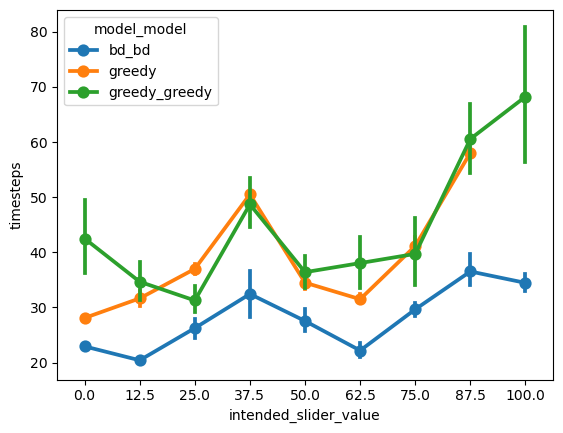

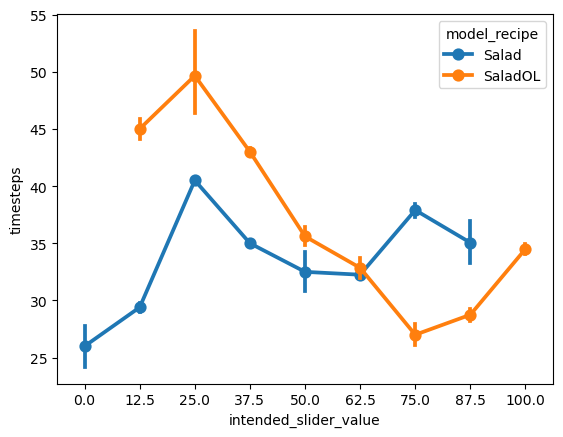

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt 

cooks_model_f = cooks_model[cooks_model.timesteps != 100]
sns.pointplot(data=cooks_model_f, x='intended_slider_value', y='timesteps', hue='model_model')
plt.show()

dish_model_f = dish_model[dish_model.timesteps != 100]
sns.pointplot(data=dish_model_f, x='intended_slider_value', y='timesteps', hue='model_recipe')
plt.show()

In [250]:
import numpy as np
import pandas as pd

def bootstrap_cooks(df, w=0.5, n_boot=1000, confidence=0.95):
    """Bootstrap mixture model for cooks trials."""
    preds = []
    for _ in range(n_boot):
        sample = df.sample(frac=1, replace=True)  # resample replicates
        means = sample.groupby("model_model")["timesteps"].mean()
        if {"bd_bd", "greedy_greedy"} <= set(means.index):
            mix = w * means["bd_bd"] + (1 - w) * means["greedy_greedy"]
            preds.append(means["greedy"] / (means["greedy"] + mix))
    # convert confidence level to percentile bounds
    alpha = 1 - confidence
    lower = 100 * (alpha / 2)
    upper = 100 * (1 - alpha / 2)
    return pd.Series({
        "model_pred": np.mean(preds),
        "ci_lower": np.percentile(preds, lower),
        "ci_upper": np.percentile(preds, upper),
        "mixture_weight": w
    })

def bootstrap_dish(df, a="Salad", b="SaladOL", n_boot=1000, confidence=0.95):
    """Bootstrap model predictions for dish trials. """
    preds = []
    for _ in range(n_boot):
        sample = df.sample(frac=1, replace=True)
        means = sample.groupby("model_recipe")["timesteps"].mean()
        if {"Salad", "SaladOL"}.issubset(means.index):
            preds.append(means["Salad"] / (means["Salad"] + means["SaladOL"]))

    alpha = 1 - confidence
    lower = 100 * (alpha / 2)
    upper = 100 * (1 - alpha / 2)

    return pd.Series({
        "model_pred": np.mean(preds),
        "ci_lower": np.percentile(preds, lower),
        "ci_upper": np.percentile(preds, upper),
    })

model_preds = pd.concat([(
    cooks_model
    .groupby("trial")
    .apply(bootstrap_cooks, w=0.7, include_groups=False)
    .reset_index()
    ), (
    dish_model
    .groupby("trial")
    .apply(bootstrap_dish, include_groups=False)
    .reset_index()
)])
model_preds = model_preds.merge(trial_metadata, left_on="trial", right_index=True, how="left")
# cooks_model.groupby(['trial', 'model_model']).timesteps.mean()
model_preds

,trial,model_pred,ci_lower,ci_upper,mixture_weight,trial_type,intended_slider_value,n_chopping_boards,n_counters
0,trial_01,0.464596,0.437666,0.496141,0.7,cooks,0.0,1,4
1,trial_02,0.481302,0.452133,0.511309,0.7,cooks,0.0,2,6
2,trial_03,0.510617,0.485298,0.531367,0.7,cooks,12.5,1,9
3,trial_04,0.599097,0.586165,0.610652,0.7,cooks,12.5,2,4
4,trial_05,0.497395,0.445665,0.544378,0.7,cooks,25.0,1,6
5,trial_06,0.471093,0.440854,0.505316,0.7,cooks,25.0,2,9
6,trial_07,0.493193,0.463787,0.518776,0.7,cooks,37.5,1,4
7,trial_08,0.639190,0.621850,0.653771,0.7,cooks,37.5,2,6
8,trial_09,0.511043,0.499966,0.521615,0.7,cooks,50.0,1,9
9,trial_10,0.562610,0.551438,0.573462,0.7,cooks,50.0,2,4


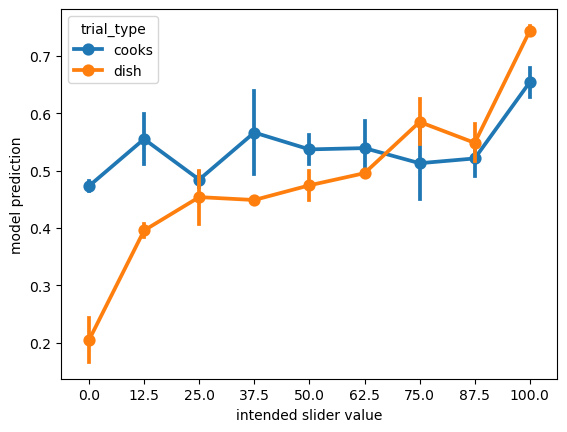

In [254]:
sns.pointplot(data=model_preds, x='intended_slider_value', y='model_pred', hue='trial_type')
plt.xlabel('intended slider value')
plt.ylabel('model prediction')
plt.show()

In [257]:
def print_trial_summaries(model_preds, cooks_model, dish_model):
    # Per-trial means by model (cooks) and recipe (dish)
    cooks_means = (
        cooks_model.groupby(['trial', 'model_model'])['timesteps']
        .mean()
        .unstack()  # columns like 'bd_bd', 'greedy', 'greedy_greedy'
    )
    dish_means = (
        dish_model.groupby(['trial', 'model_recipe'])['timesteps']
        .mean()
        .unstack()  # columns like 'Salad', 'SaladOL'
    )

    # Helper for safe numeric formatting
    def fmt(x, digits=2):
        return "NA" if pd.isna(x) else f"{float(x):.{digits}f}"

    # Ensure we iterate in numeric trial order: trial_01, trial_02, ...
    trials_sorted = sorted(model_preds['trial'].unique(),
                           key=lambda s: int(s.split('_')[-1]))

    preds_ix = model_preds.set_index('trial', drop=False)

    for trial in trials_sorted:
        # pull point estimate and intended value
        row = preds_ix.loc[trial]
        slider_pred = row['model_pred']
        intended = row['intended_slider_value']

        # decide cooks vs dish by trial number
        trial_num = int(trial.split('_')[-1])

        if trial_num <= 18:
            # cooks
            cm = cooks_means.loc[trial] if trial in cooks_means.index else pd.Series(dtype=float)
            greedy = cm.get('greedy', pd.NA)
            greedy_greedy = cm.get('greedy_greedy', pd.NA)
            bd_bd = cm.get('bd_bd', pd.NA)

            print(
                '"\n'
                f'{trial}\n'
                f'slider_pred: {fmt(slider_pred, 2)}\n'
                f'intended_value: {fmt(intended, 1)}\n'
                f'greedy: {fmt(greedy, 1)}\n'
                f'greedy_greedy: {fmt(greedy_greedy, 1)}\n'
                f'bd_bd: {fmt(bd_bd, 2)}\n'
                '"\n'
            )
        else:
            # dish
            dm = dish_means.loc[trial] if trial in dish_means.index else pd.Series(dtype=float)
            salad = dm.get('Salad', pd.NA)
            salad_ol = dm.get('SaladOL', pd.NA)

            print(
                '"\n'
                f'{trial}\n'
                f'slider_pred: {fmt(slider_pred, 2)}\n'
                f'intended_value: {fmt(intended, 1)}\n'
                f'Salad: {fmt(salad, 2)}\n'
                f'SaladOL: {fmt(salad_ol, 2)}\n'
                '"\n'
            )

# Example call:
print_trial_summaries(model_preds, cooks_model, dish_model)


"
trial_01
slider_pred: 0.46
intended_value: 0.0
greedy: 28.2
greedy_greedy: 55.0
bd_bd: 22.95
"

"
trial_02
slider_pred: 0.48
intended_value: 0.0
greedy: 28.0
greedy_greedy: 47.3
bd_bd: 22.95
"

"
trial_03
slider_pred: 0.51
intended_value: 12.5
greedy: 27.3
greedy_greedy: 38.7
bd_bd: 20.95
"

"
trial_04
slider_pred: 0.60
intended_value: 12.5
greedy: 36.0
greedy_greedy: 33.9
bd_bd: 19.90
"

"
trial_05
slider_pred: 0.50
intended_value: 25.0
greedy: 40.0
greedy_greedy: 49.9
bd_bd: 36.55
"

"
trial_06
slider_pred: 0.47
intended_value: 25.0
greedy: 34.0
greedy_greedy: 73.2
bd_bd: 23.35
"

"
trial_07
slider_pred: 0.49
intended_value: 37.5
greedy: 52.0
greedy_greedy: 59.2
bd_bd: 50.95
"

"
trial_08
slider_pred: 0.64
intended_value: 37.5
greedy: 49.0
greedy_greedy: 43.9
bd_bd: 20.70
"

"
trial_09
slider_pred: 0.51
intended_value: 50.0
greedy: 37.7
greedy_greedy: 41.6
bd_bd: 33.70
"

"
trial_10
slider_pred: 0.56
intended_value: 50.0
greedy: 31.3
greedy_greedy: 31.1
bd_bd: 21.40
"

"
trial_11
s